# Descargar boletines del BCP

Notebook para ejecutar el flujo completo desde el entorno virtual `albertito`.


## 1. Validar entorno virtual


In [1]:
from pathlib import Path
venv_path = Path('albertito')
if not venv_path.exists():
    raise RuntimeError('No se encontro el venv \'albertito\'. Crea uno con python -m venv albertito')
else:
    print('Venv encontrado en:', venv_path.resolve())


Venv encontrado en: D:\Personal\Vibe_Coding\albertito


## 2. Instalar o actualizar dependencias dentro del venv


In [2]:
import subprocess
from pathlib import Path
python_bin = Path('albertito') / 'Scripts' / 'python.exe'
cmd = [str(python_bin), '-m', 'pip', 'install', '-r', 'requirements.txt']
print('Ejecutando:', ' '.join(cmd))
subprocess.run(cmd, check=True)


Ejecutando: albertito\Scripts\python.exe -m pip install -r requirements.txt


CompletedProcess(args=['albertito\\Scripts\\python.exe', '-m', 'pip', 'install', '-r', 'requirements.txt'], returncode=0)

## 3. Ejecutar el downloader


In [7]:
import subprocess
from pathlib import Path
python_bin = Path('albertito') / 'Scripts' / 'python.exe'
cmd = [str(python_bin), 'bcp_downloader.py']
print('Ejecutando:', ' '.join(cmd))
subprocess.run(cmd, check=True)


Ejecutando: albertito\Scripts\python.exe bcp_downloader.py


CompletedProcess(args=['albertito\\Scripts\\python.exe', 'bcp_downloader.py'], returncode=0)

## 4. Revisar archivos generados


In [4]:
from pathlib import Path
result_dir = Path('descargas')
if not result_dir.exists():
    print('No existe el directorio descargas')
else:
    for path in sorted(result_dir.glob('*')):
        size = path.stat().st_size
        print(f'{path.name} - {size:,} bytes')


CSBI.csv - 88,084,259 bytes
CSFI.csv - 88,081,613 bytes
ERBI.csv - 67,212,713 bytes
ERFI.csv - 67,109,345 bytes
tabla_de_bancos.xlsx - 32,715,301 bytes
tabla_de_financieras.xlsx - 24,361,486 bytes
TCBI.csv - 18,874,794 bytes
TCFI.csv - 20,971,690 bytes


## 5. Importar CSVs a DuckDB (staging)


In [1]:

import unicodedata
from pathlib import Path
import duckdb
import pandas as pd

DB_PATH = Path('data/mi_base.duckdb')
CSV_DIR = Path('descargas')
CSV_DIR.mkdir(exist_ok=True)

conn = duckdb.connect(str(DB_PATH))

def normalize_columns(df):
    rename = {}
    for col in df.columns:
        base = ''.join(c for c in unicodedata.normalize('NFKD', str(col)) if not unicodedata.combining(c))
        base = base.strip().lower().replace(' ', '_').replace('__', '_')
        rename[col] = base
    return df.rename(columns=rename)

CSV_FILES = {
    'em_tmp_bcp_csbi': 'CSBI.csv',
    'em_tmp_bcp_csfi': 'CSFI.csv',
    'em_tmp_bcp_tcbi': 'TCBI.csv',
    'em_tmp_bcp_tcfi': 'TCFI.csv',
    'em_tmp_bcp_erbi': 'ERBI.csv',
    'em_tmp_bcp_erfi': 'ERFI.csv',
}

for table, filename in CSV_FILES.items():
    csv_path = CSV_DIR / filename
    if not csv_path.exists():
        raise FileNotFoundError(f'No se encontro el archivo {csv_path}')
    df = normalize_columns(pd.read_csv(csv_path))
    if 'fecha' in df.columns:
        df['fecha'] = pd.to_datetime(df['fecha'])
    for col in ['codigo_entidad', 'codigo_moneda']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    for col in ['cartera_vencida', 'cartera_vigente', 'total', 'importe']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    temp_name = f'tmp_{table}'
    conn.register(temp_name, df)
    conn.execute(f"CREATE OR REPLACE TABLE {table} AS SELECT * FROM {temp_name}")
    conn.unregister(temp_name)

print('Tablas staging disponibles:')
display(conn.execute("SELECT table_name FROM information_schema.tables WHERE table_schema='main' AND table_name LIKE 'em_tmp_bcp_%' ORDER BY table_name").df())



Tablas staging disponibles:


,table_name
0,em_tmp_bcp_csbi
1,em_tmp_bcp_csfi
2,em_tmp_bcp_erbi
3,em_tmp_bcp_erfi
4,em_tmp_bcp_tcbi
5,em_tmp_bcp_tcfi


## 6. Transformaciones SQL (equivalente stored procedures)


In [5]:
ENTITY_REMAP = {1039: 1046, 2007: 1046, 1041: 1042, 1028: 1008, 1007: 1004, 2036: 1047, 2077: 1020, 1040: 1020, 2081: 1045}
ENTITY_NAMES = {
    1046: 'UENO',
    1047: 'ZETA',
    1045: 'SOLAR',
    1042: 'ATLAS/FAMILIAR',
    1043: 'BANCOP',
    1030: 'BASA',
    1003: 'BNA',
    1002: 'BNF',
    1006: 'CITIBANK',
    1020: 'CONTINENTAL/RIO',
    1005: 'DO BRASIL',
    1004: 'GNB',
    1044: 'INTERFISA',
    1017: 'ITAU',
    1008: 'SUDAMERIS',
    2037: 'CEFISA',
    2080: 'FIC',
    2071: 'FINLATINA',
    2013: 'FPJ',
    2078: 'TU FINANCIERA'
}

def build_case(field, mapping):
    lines = [f"    WHEN {field} = {orig} THEN {dest}" for orig, dest in mapping.items()]
    return "CASE\n" + "\n".join(lines) + f"\n    ELSE {field}\nEND"

entity_case = build_case('codigo_entidad', ENTITY_REMAP)
name_case_lines = [f"    WHEN codigo_entidad = {code} THEN '{name}'" for code, name in ENTITY_NAMES.items()]
entity_name_case = "CASE\n" + "\n".join(name_case_lines) + "\n    ELSE 'ERROR'\nEND"

conn.execute("CREATE OR REPLACE TABLE em_tmp_bcp_csi AS SELECT * FROM em_tmp_bcp_csbi UNION ALL SELECT * FROM em_tmp_bcp_csfi")
conn.execute(f"CREATE OR REPLACE TABLE em_tmp_bcp_csr AS SELECT fecha, {entity_case} AS codigo_entidad, actividad_destino_vs2, cartera_vencida, cartera_vigente FROM em_tmp_bcp_csi")
conn.execute("CREATE OR REPLACE TABLE em_tmp_bcp_csc AS SELECT fecha, codigo_entidad, actividad_destino_vs2, COALESCE(SUM(cartera_vigente),0) AS cartera_vigente, COALESCE(SUM(cartera_vencida),0) AS cartera_vencida FROM em_tmp_bcp_csr GROUP BY 1,2,3 ORDER BY 1,2,3")
conn.execute(f"CREATE OR REPLACE TABLE em_bcp_credito_sector AS SELECT fecha, {entity_name_case} AS entidad, actividad_destino_vs2 AS actividad, cartera_vigente, cartera_vencida, cartera_vigente + cartera_vencida AS cartera_total FROM em_tmp_bcp_csc ORDER BY fecha, codigo_entidad, actividad_destino_vs2")

conn.execute("CREATE OR REPLACE TABLE em_tmp_bcp_tci AS SELECT * FROM em_tmp_bcp_tcbi UNION ALL SELECT * FROM em_tmp_bcp_tcfi")
conn.execute(f"CREATE OR REPLACE TABLE em_tmp_bcp_tcr AS SELECT fecha, {entity_case} AS codigo_entidad, clasificacion, total FROM em_tmp_bcp_tci")
conn.execute("CREATE OR REPLACE TABLE em_tmp_bcp_tcc AS SELECT fecha, codigo_entidad, clasificacion, COALESCE(SUM(total),0) AS total FROM em_tmp_bcp_tcr GROUP BY 1,2,3 ORDER BY 1,2,3")
conn.execute(f"CREATE OR REPLACE TABLE em_bcp_tc AS SELECT fecha AS fecha, {entity_name_case} AS entidad, upper(clasificacion) AS clasificacion, total FROM em_tmp_bcp_tcc ORDER BY fecha, codigo_entidad, clasificacion")

conn.execute("CREATE OR REPLACE TABLE em_tmp_bcp_eri AS SELECT * FROM em_tmp_bcp_erbi UNION ALL SELECT * FROM em_tmp_bcp_erfi")
conn.execute(f"CREATE OR REPLACE TABLE em_tmp_bcp_err AS SELECT fecha, {entity_case} AS codigo_entidad, sub_rubro, codigo_moneda, importe, reporte FROM em_tmp_bcp_eri")
conn.execute("CREATE OR REPLACE TABLE em_tmp_bcp_erc_1 AS SELECT fecha, codigo_entidad, sub_rubro, COALESCE(SUM(importe),0) AS importe, MIN(reporte) AS reporte FROM em_tmp_bcp_err GROUP BY 1,2,3 ORDER BY 1,2,3")
conn.execute(f"CREATE OR REPLACE TABLE em_tmp_bcp_erc AS SELECT fecha, {entity_name_case} AS entidad, sub_rubro, importe, reporte FROM em_tmp_bcp_erc_1 ORDER BY fecha, entidad, sub_rubro")

from pathlib import Path as _Path
index_path = _Path('data/em_bcp_eerr_index.csv')
if index_path.exists():
    df_index = normalize_columns(pd.read_csv(index_path))
    temp_idx = 'tmp_eerr_index'
    conn.register(temp_idx, df_index)
    conn.execute(f"CREATE OR REPLACE TABLE em_bcp_eerr_index AS SELECT * FROM {temp_idx}")
    conn.unregister(temp_idx)
else:
    conn.execute("CREATE TABLE IF NOT EXISTS em_bcp_eerr_index (sub_rubro_base TEXT, clasificacion TEXT, rubro TEXT, sub_rubro_reporte TEXT)")
    print('Aviso: no se encontro data/em_bcp_eerr_index.csv; columnas de clasificacion quedaran nulas.')

conn.execute("CREATE OR REPLACE TABLE em_bcp_estado_resultados AS SELECT a.fecha, a.entidad, idx.clasificacion, idx.rubro, idx.sub_rubro_reporte, a.sub_rubro, a.reporte, a.importe FROM em_tmp_bcp_erc a LEFT JOIN em_bcp_eerr_index idx ON a.sub_rubro = idx.sub_rubro_base ORDER BY a.fecha, a.entidad, a.sub_rubro")

for table in ['em_tmp_bcp_csi', 'em_tmp_bcp_csr', 'em_tmp_bcp_csc', 'em_tmp_bcp_tci', 'em_tmp_bcp_tcr', 'em_tmp_bcp_tcc', 'em_tmp_bcp_eri', 'em_tmp_bcp_err', 'em_tmp_bcp_erc_1', 'em_tmp_bcp_erc']:
    conn.execute(f"DROP TABLE IF EXISTS {table}")

print('Tablas finales disponibles: em_bcp_credito_sector, em_bcp_tc, em_bcp_estado_resultados')


Aviso: no se encontro data/em_bcp_eerr_index.csv; columnas de clasificacion quedaran nulas.
Tablas finales disponibles: em_bcp_credito_sector, em_bcp_tc, em_bcp_estado_resultados


## 7. Tablas resultantes


In [6]:

tables_info = []
for table in ['em_bcp_credito_sector', 'em_bcp_tc', 'em_bcp_estado_resultados']:
    info = conn.execute(f"SELECT COUNT(*) AS filas, MIN(fecha) AS min_fecha, MAX(fecha) AS max_fecha FROM {table}").df()
    info.insert(0, 'tabla', table)
    tables_info.append(info)
display(pd.concat(tables_info, ignore_index=True))



,tabla,filas,min_fecha,max_fecha
0,em_bcp_credito_sector,26588,2016-01-31,2025-08-31
1,em_bcp_tc,4362,2016-01-31,2025-08-31
2,em_bcp_estado_resultados,159398,2016-01-31,2025-08-31


## 8. Analisis y graficos


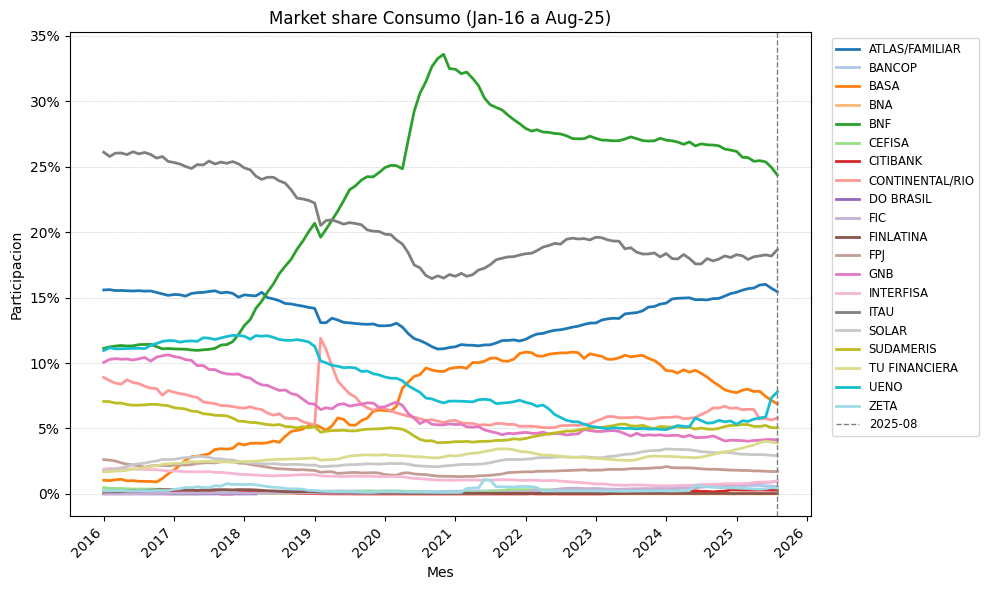

Figura guardada en out\share_consumo.png


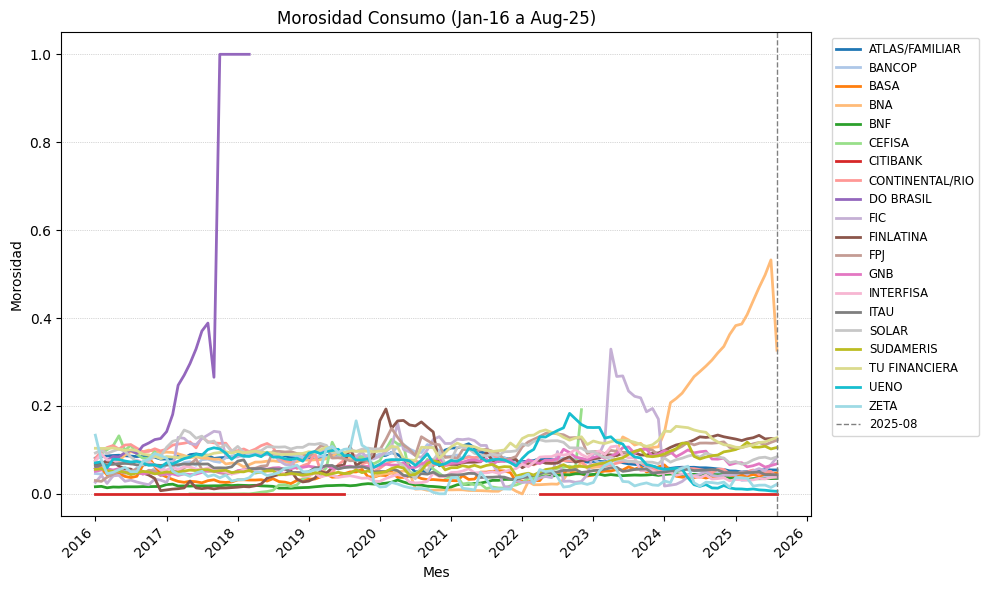

Figura guardada en out\morosidad_consumo.png


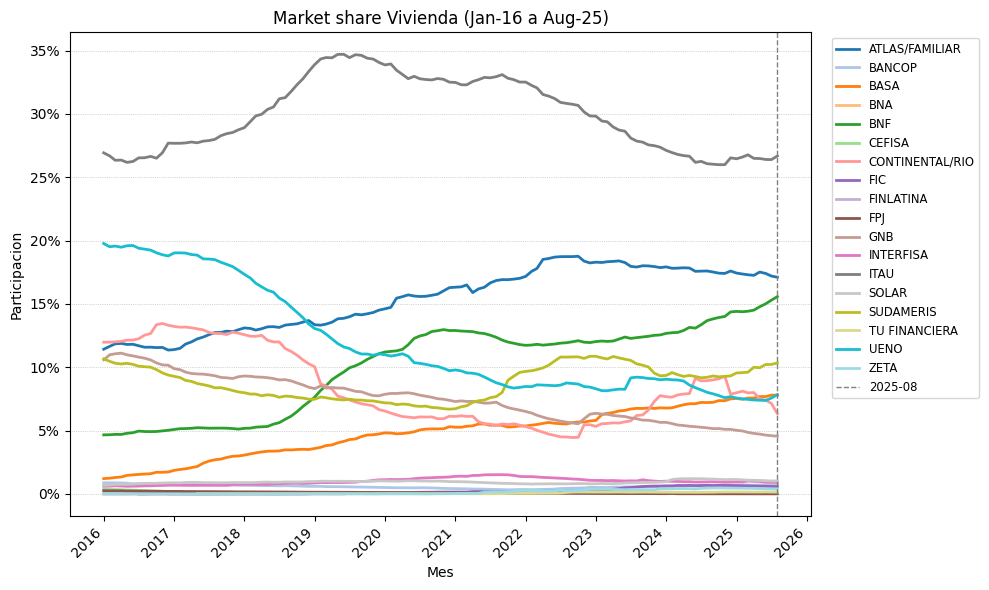

Figura guardada en out\share_vivienda.png


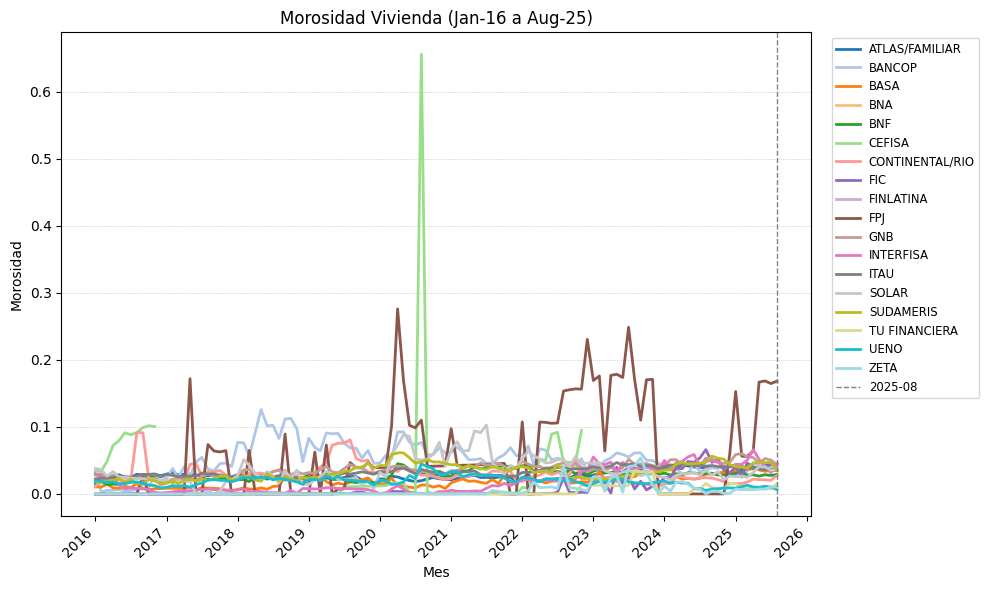

Figura guardada en out\morosidad_vivienda.png


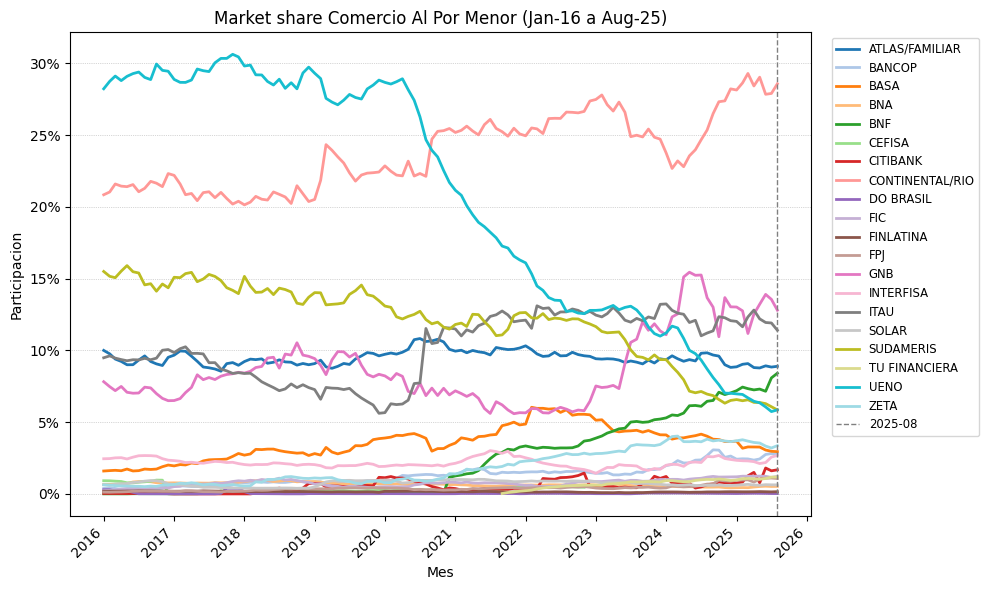

Figura guardada en out\share_comercio_menor.png


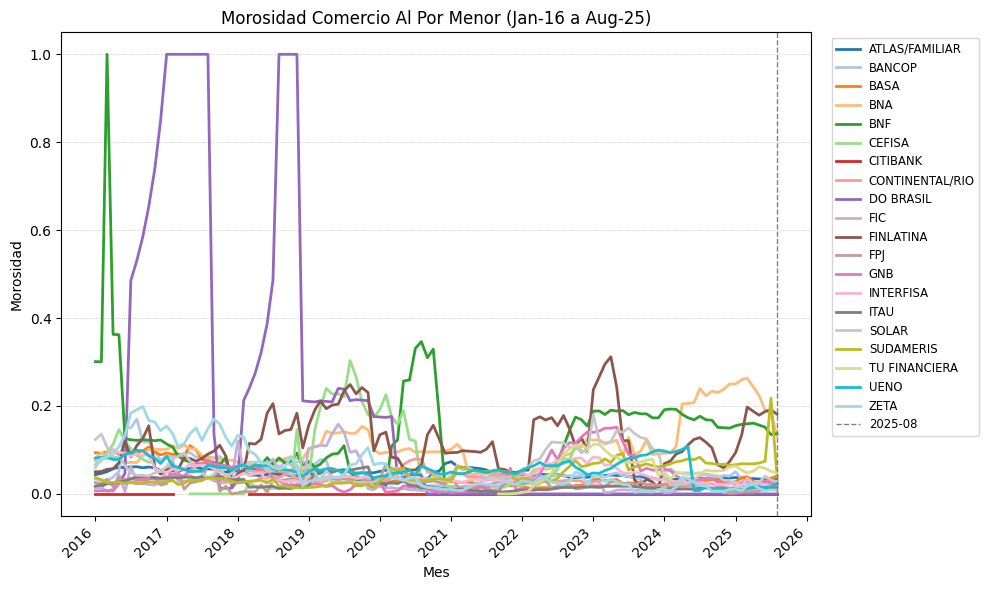

Figura guardada en out\morosidad_comercio_menor.png


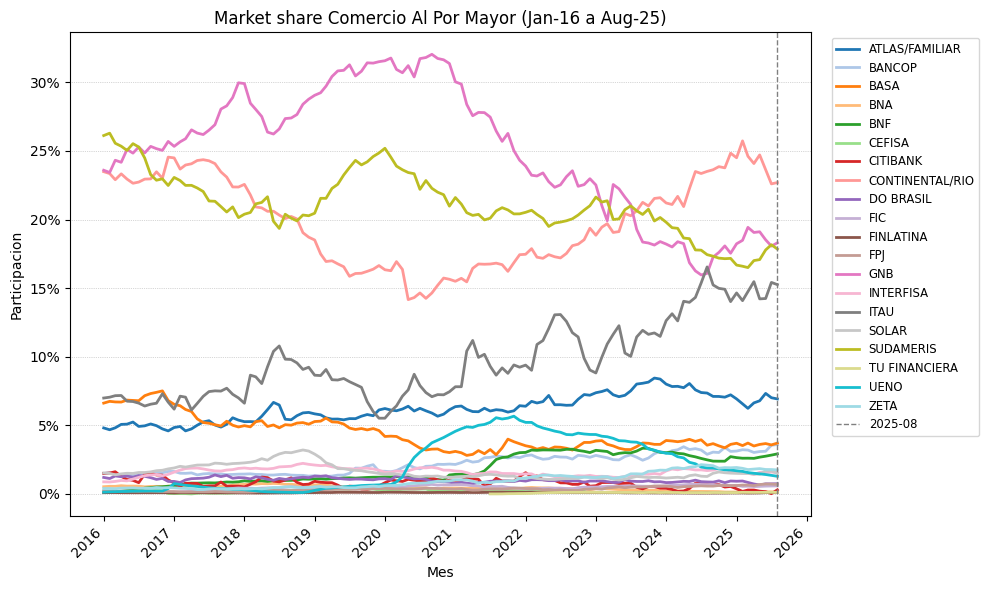

Figura guardada en out\share_comercio_mayor.png


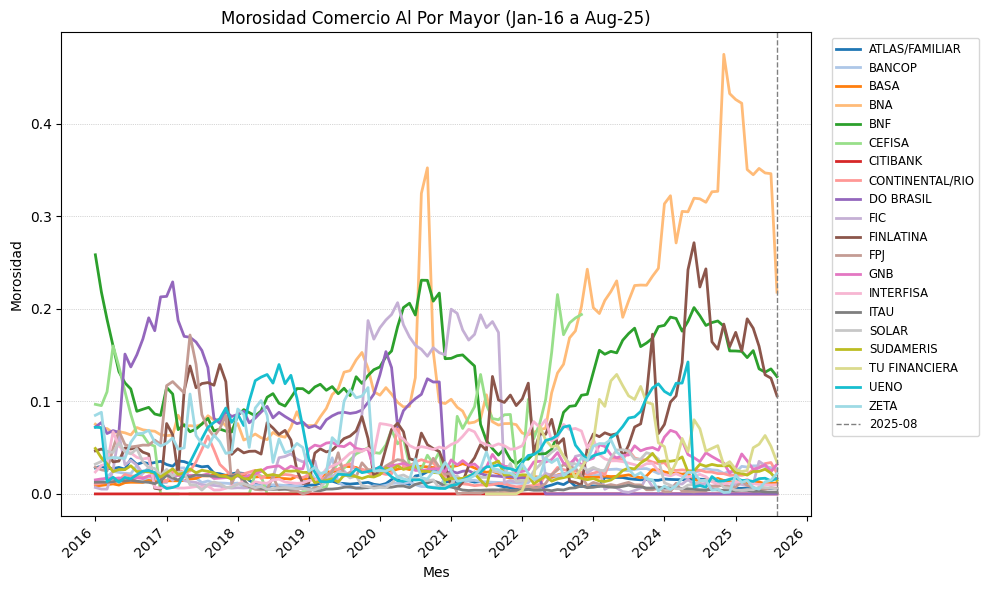

Figura guardada en out\morosidad_comercio_mayor.png


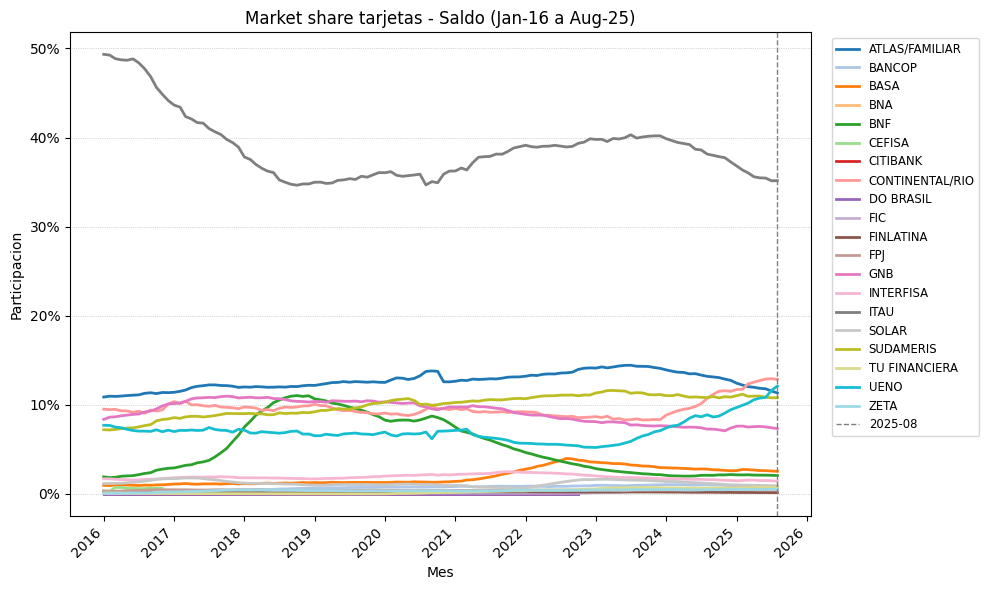

Figura guardada en out\share_tarjetas_saldo.png


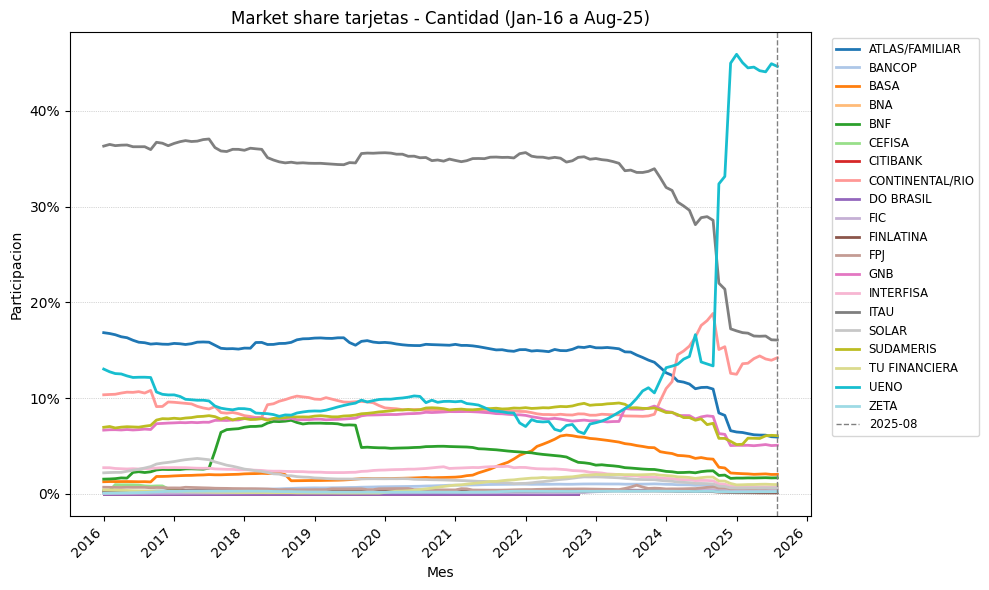

Figura guardada en out\share_tarjetas_cantidad.png


In [7]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

OUT_DIR = Path('out')
OUT_DIR.mkdir(exist_ok=True)

def fmt_percent(ax):
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

def plot_lines(df, value_col, title, ylabel, filename):
    if df.empty:
        print(f'Sin datos para {title}')
        return
    banks = sorted(df['entidad'].unique())
    colors = plt.colormaps['tab20'](np.linspace(0, 1, max(len(banks), 1)))
    fig, ax = plt.subplots(figsize=(10, 6))
    cutoff = df['mes'].max()
    for color, (bank, group) in zip(colors, df.groupby('entidad')):
        ax.plot(group['mes'], group[value_col], label=bank, color=color, linewidth=2)
    ax.axvline(cutoff, color='gray', linestyle='--', linewidth=1, label=cutoff.strftime('%Y-%m'))
    ax.set_title(title)
    ax.set_xlabel('Mes')
    ax.set_ylabel(ylabel)
    if 'share' in value_col:
        fmt_percent(ax)
    ax.grid(True, axis='y', linestyle=':', linewidth=0.5)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()
    path = OUT_DIR / filename
    fig.savefig(path, dpi=150)
    plt.show()
    print(f'Figura guardada en {path}')

def fetch_credito(producto):
    sql = """
        SELECT date_trunc('month', fecha) AS mes, entidad, SUM(cartera_total) AS monto, SUM(cartera_vencida) AS vencida
        FROM em_bcp_credito_sector
        WHERE upper(actividad) = ?
        GROUP BY 1,2
        ORDER BY 1,2
    """
    df = conn.execute(sql, [producto.upper()]).df()
    if df.empty:
        return df
    df['share'] = df.groupby('mes')['monto'].transform(lambda x: x / x.sum())
    df['morosidad'] = np.where(df['monto'] > 0, df['vencida'] / df['monto'], np.nan)
    return df

def plot_credito(producto, sufijo):
    df = fetch_credito(producto)
    if df.empty:
        print(f'Sin datos para {producto}')
        return
    periodo = f"{df['mes'].min():%b-%y} a {df['mes'].max():%b-%y}"
    plot_lines(df, 'share', f'Market share {producto.title()} ({periodo})', 'Participacion', f'share_{sufijo}.png')
    plot_lines(df, 'morosidad', f'Morosidad {producto.title()} ({periodo})', 'Morosidad', f'morosidad_{sufijo}.png')

productos = [
    ('CONSUMO', 'consumo'),
    ('VIVIENDA', 'vivienda'),
    ('COMERCIO AL POR MENOR', 'comercio_menor'),
    ('COMERCIO AL POR MAYOR', 'comercio_mayor'),
]
for producto, sufijo in productos:
    plot_credito(producto, sufijo)

def fetch_tarjeta(clasificacion):
    sql = """
        SELECT date_trunc('month', fecha) AS mes, entidad, SUM(total) AS total
        FROM em_bcp_tc
        WHERE upper(clasificacion) = ?
        GROUP BY 1,2
        ORDER BY 1,2
    """
    df = conn.execute(sql, [clasificacion.upper()]).df()
    if df.empty:
        return df
    df['share'] = df.groupby('mes')['total'].transform(lambda x: x / x.sum())
    return df

for clasificacion, sufijo in [('SALDO', 'saldo'), ('CANTIDAD', 'cantidad')]:
    df_tar = fetch_tarjeta(clasificacion)
    if df_tar.empty:
        print(f'Sin datos para tarjetas ({clasificacion})')
        continue
    periodo = f"{df_tar['mes'].min():%b-%y} a {df_tar['mes'].max():%b-%y}"
    plot_lines(df_tar, 'share', f'Market share tarjetas - {clasificacion.title()} ({periodo})', 'Participacion', f'share_tarjetas_{sufijo}.png')

conn.close()

